In this notebook we fit linear filters predicting neural activity from sensory inputs.

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from aux import make_extended_predictor_matrix, calc_r2
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from plot import set_font_size

import CONFIG as C

# Define function to fit linear filter

In [2]:
def fit_filter(trial, x_name, y_name, x_wdw, train, test, model):
    """
    Given a trial, fit a linear filter mapping an input (x_name) time-series to 
    an output (y_name) time series and return fit results.
    
    :param x_wdw: (t_start, t_end) relative to timepoint of prediction
    :param train: training mask (must have same size as trial.dl.t)
    :param test: test mask (must have same size as trial.dl.t)
    
    :return:
        FitResult object with attributes:
            trial_name
            
            x_name
            y_name
            
            x_wdw
            x_wdw_dsct
            
            train
            test
            
            t
            x
            y
            
            r2_train
            y_hat_train
            
            r2_test
            y_hat_test
            
            t_h
            h
    """
    t = getattr(trial.dl, 't')
    
    assert len(t) == len(train) == len(test)
    
    # munge data into arguments for LinearRegression.fit
    x = getattr(trial.dl, x_name)
    
    vs = {x_name: x}
    
    x_wdw_dsct = (int(round(x_wdw[0] / C.DT)), int(round(x_wdw[1] / C.DT)))
    wdws_dsct = {x_name: x_wdw_dsct}
    
    order = [x_name]
    
    x_xtd = make_extended_predictor_matrix(vs=vs, windows=wdws_dsct, order=order)
    y = getattr(trial.dl, y_name)
    
    # get valid mask
    valid = np.all(~np.isnan(x_xtd), axis=1) & (~np.isnan(y))
    
    # prepare result dict
    fit_result_dict = {
        'trial_name': trial.name,
        'x_name': x_name,
        'y_name': y_name,
        'x_wdw': x_wdw,
        'x_wdw_dsct': x_wdw_dsct,
        'train': train,
        'test': test,
        't': t,
        'x': x,
        'y': y,
        't_h': np.arange(*x_wdw_dsct) * C.DT,
    }
    
    # fit model if possible
    if np.sum(valid & train) > x_xtd.shape[1]:
        
        # fit model
        rgr = model()
        rgr.fit(x_xtd[valid & train], y[valid & train])
        
        # make training predictions
        y_hat_train = np.nan * np.zeros(y.shape)
        y_hat_train[valid & train] = rgr.predict(x_xtd[valid & train])
        
        fit_result_dict['r2_train'] = calc_r2(y[valid & train], y_hat_train[valid & train])
        fit_result_dict['y_hat_train'] = y_hat_train
        
        # make test predictions
        if np.sum(valid & test) > 0:
            y_hat_test = np.nan * np.zeros(y.shape)
            y_hat_test[valid & test] = rgr.predict(x_xtd[valid & test])
            
            fit_result_dict['r2_test'] = calc_r2(y[valid & test], y_hat_test[valid & test])
            fit_result_dict['y_hat_test'] = y_hat_test
        
        else:
            print('No valid test data.')
            
            fit_result_dict['y_hat_test'] = np.nan * np.zeros(y.shape)
            fit_result_dict['r2_test'] = np.nan
            
        # store filter
        fit_result_dict['h'] = rgr.coef_
            
    else:
        print('Not enough data to fit model.')
        
        fit_result_dict['r2_train'] = np.nan
        fit_result_dict['y_hat_train'] = np.nan * np.zeros(y.shape)
        
        fit_result_dict['r2_test'] = np.nan
        fit_result_dict['y_hat_test'] = np.nan * np.zeros(y.shape)
        
        fit_result_dict['h'] = np.nan * np.ones(x_xtd.shape[1])
        
    return Generic(**fit_result_dict)

# Test filter-fitting function

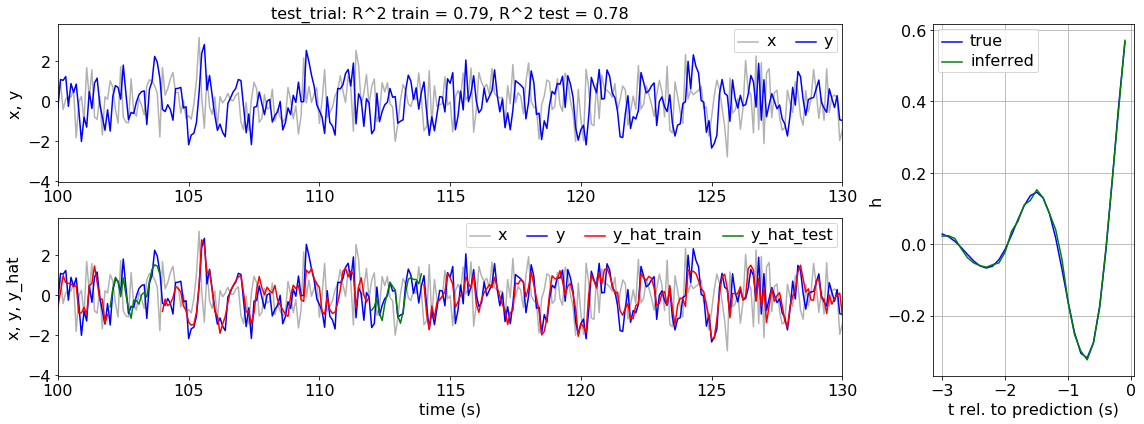

In [3]:
def test_fit_filter(*t_lim):
    np.random.seed(0)
    
    # mock data
    t = np.arange(0, 300, C.DT)
    x = np.random.normal(0, 1, t.shape)
    
    t_h = np.arange(-3, 0, C.DT)
    h = np.exp(t_h/1) * np.cos(4 * t_h)
    h /= np.linalg.norm(h)
    
    y = np.convolve(x, np.concatenate([h, np.zeros(h.shape)])[::-1], mode='same') \
        + np.random.normal(0, .5, t.shape)
    
    # mock data loader
    dl = Generic(t=t, x=x, y=y)
    
    # mock trial
    trial = Generic(name='test_trial', dl=dl)
    
    # make train and test masks
    train, test = random_chunk_split(t, 0.75, 2)
    
    # fit function
    rslt = fit_filter(trial, 'x', 'y', (-3, 0), train, test, model=LinearRegression)
    
    # plot true and found filters
    gs = gridspec.GridSpec(2, 4)
    
    fig = plt.figure(figsize=(16, 6), tight_layout=True)
    ax_0 = fig.add_subplot(gs[0, :3])
    ax_1 = fig.add_subplot(gs[1, :3], sharex=ax_0)
    ax_2 = fig.add_subplot(gs[:, 3])
    
    # plot x, y, y_hat_train, y_hat_test
    ax_0.plot(t, x, color='k', alpha=0.3)
    ax_0.plot(t, y, color='b')
    
    ax_0.set_ylabel('x, y')
    ax_0.set_title('{0}: R^2 train = {1:.2f}, R^2 test = {2:.2f}'.format(
        rslt.trial_name, rslt.r2_train, rslt.r2_test))
    
    ax_0.legend(['x', 'y'], ncol=2)
    
    ax_1.plot(t, x, color='k', alpha=0.3)
    ax_1.plot(t, y, color='b')
    ax_1.plot(t, rslt.y_hat_train, color='r')
    ax_1.plot(t, rslt.y_hat_test, color='g')
    
    ax_1.set_xlim(*t_lim)
    
    ax_1.set_xlabel('time (s)')
    ax_1.set_ylabel('x, y, y_hat')
    ax_1.legend(['x', 'y', 'y_hat_train', 'y_hat_test'], ncol=4)
    
    # plot filters
    ax_2.plot(t_h, h, color='b')
    ax_2.plot(t_h, rslt.h, color='g')
    
    ax_2.grid()
    
    ax_2.set_xlabel('t rel. to prediction (s)')
    ax_2.set_ylabel('h')
    
    ax_2.legend(['true', 'inferred'])
    
    for ax in [ax_0, ax_1, ax_2]:
        set_font_size(ax, 16)
        
test_fit_filter(100, 130)

# Fit linear filters

In [4]:
N_SPLITS = 30
SPLIT_FRAC = 0.8
CHUNK_SIZE = 2
X_WDW = (-3, 0)

EXPTS = ['white_odor_fluct']
GS = ['g2', 'g3', 'g4', 'g5']

X_NAMES = ['odor_binary', 'odor_pid', 'w_air', 'air']
Y_NAMES = sum([[g + sfx for g in GS] for sfx in 'rlsd'], [])

MODELS = {
    'odor_binary': LinearRegression,
    'odor_pid': LinearRegression,
    'w_air': lambda: Lasso(alpha=0.5),
    'air': LinearRegression,
}

COLS = list(cproduct(X_NAMES, Y_NAMES))

BINS = np.linspace(-.1, 1, 111)
BINCS = 0.5 * (BINS[:-1] + BINS[1:])

COLORS = {
    'odor_binary': np.array(C.COLORS_RGB['odor_binary'])/255,
    'odor_pid': np.array(C.COLORS_RGB['odor_pid'])/255,
    'w_air': np.array(C.COLORS_RGB['w_air'])/255,
    'air': np.array([153, 51, 255])/255,
}

In [5]:
# load trials
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.expt.in_(EXPTS)).all()
session.close()

# load data and create a moving average 
for trial in trials:
    trial.dl = DataLoader(trial, 0, None)

In [6]:
df_r2 = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])
df_h = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])
df_xmpl = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])

for trial in trials:
    print('Fitting trial {}...'.format(trial.name))
    t = trial.dl.t
    
    # loop over all x, y variable pairs
    for x_name, y_name in COLS:
        
        model = MODELS[x_name]
        rslts = []
        
        for ctr in range(N_SPLITS):
            
            # get training/test split
            train, test = random_chunk_split(t, SPLIT_FRAC, CHUNK_SIZE)
            
            # fit model
            rslt = fit_filter(
                trial=trial, x_name=x_name, y_name=y_name, x_wdw=X_WDW,
                train=train, test=test, model=model)
            
            rslts.append(rslt)
            
            if ctr == 0:
                df_xmpl.loc[trial.name][(x_name, y_name)] = deepcopy(rslt)
        
        df_r2.loc[trial.name][(x_name, y_name)] = np.nanmean([rslt.r2_test for rslt in rslts])
        df_h.loc[trial.name][(x_name, y_name)] = np.array([
            np.nanmean(np.array([rslt.t_h for rslt in rslts]), axis=0),
            np.nanmean(np.array([rslt.h for rslt in rslts]), axis=0),
            np.nanstd(np.array([rslt.h for rslt in rslts]), axis=0),
        ])

Fitting trial 20171130.Fly1.3...
Fitting trial 20171130.Fly1.4...
Fitting trial 20171130.Fly1.5...
Fitting trial 20171130.Fly1.6...
Fitting trial 20171130.Fly2.1...
Fitting trial 20171130.Fly2.2...
Fitting trial 20171130.Fly3.3...
Fitting trial 20171130.Fly3.4...
Fitting trial 20171130.Fly3.5...
Fitting trial 20171130.Fly3.6...
Fitting trial 20171130.Fly3.7...
Fitting trial 20171130.Fly4.4...
Fitting trial 20171130.Fly4.5...
Fitting trial 20171130.Fly4.6...
Fitting trial 20171130.Fly4.7...
Fitting trial 20171130.Fly4.8...
Fitting trial 20171130.Fly5.1...
Fitting trial 20171130.Fly5.2...
Fitting trial 20171130.Fly5.3...
Fitting trial 20171130.Fly5.4...
Fitting trial 20171130.Fly5.5...
Fitting trial 20171204.Fly2.3...
Fitting trial 20171204.Fly2.4...
Fitting trial 20171204.Fly2.5...
Fitting trial 20171204.Fly2.6...


# Plot R2 for different filter types

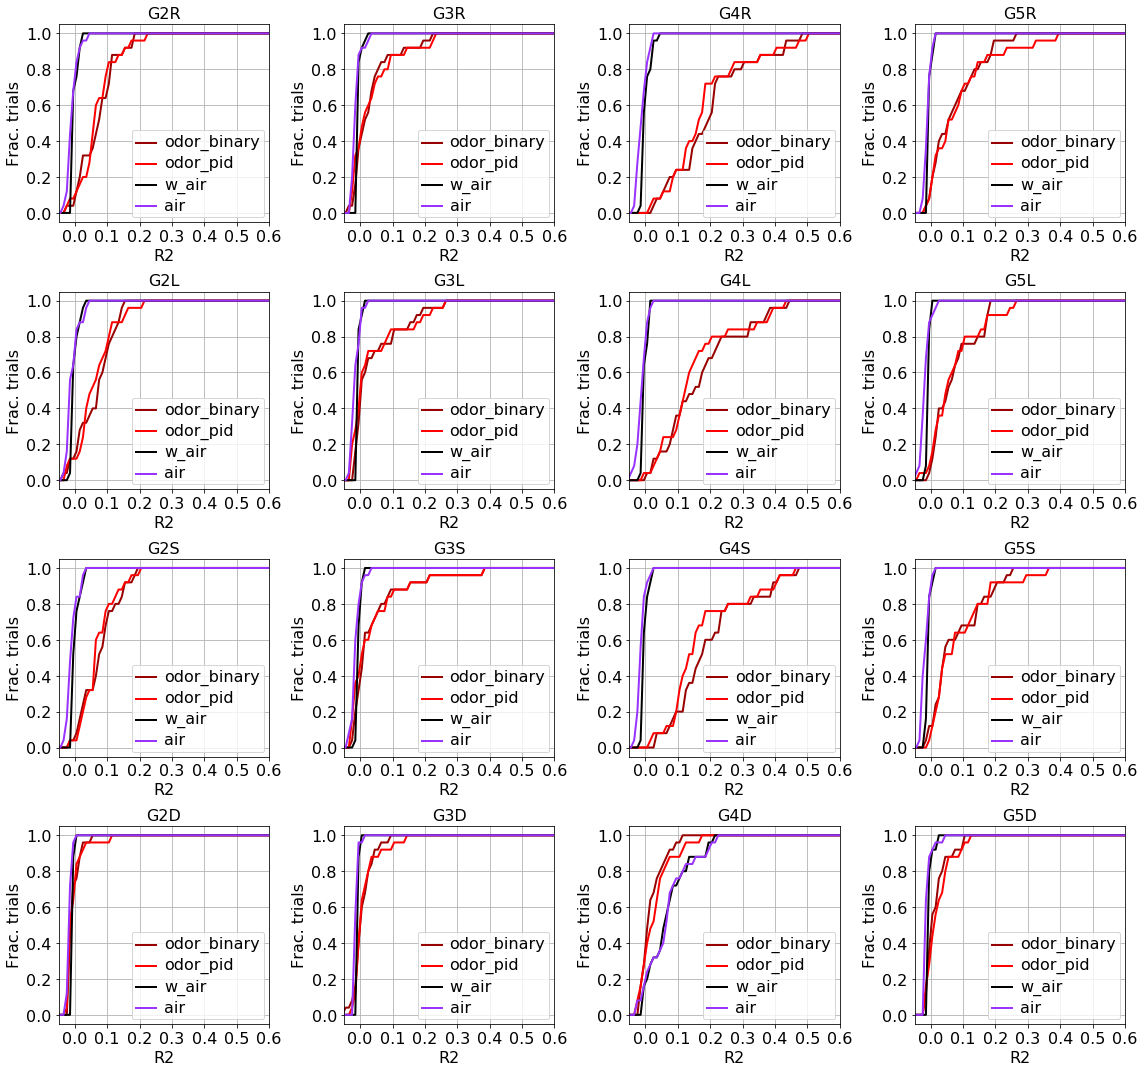

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(16, 15), tight_layout=True)

for ctr, (y_name, ax) in enumerate(zip(Y_NAMES, axs.flatten())):
    for x_name in X_NAMES:
        
        # get all R2s
        r2s = df_r2[(x_name, y_name)].as_matrix()
        
        # plot cumulative histogram
        cts, bins = np.histogram(r2s, bins=BINS)
        cts = cts.cumsum().astype(float)
        cts /= cts[-1]
        
        color = COLORS[x_name]
        
        ax.plot(BINCS, cts, color=color, lw=2)
        
    ax.set_title(y_name.upper())
    
    ax.legend(X_NAMES, ncol=1, loc='best')
        
for ax in axs.flatten():
    ax.set_xlim(-0.05, 0.6)
    ax.set_ylim(-0.05, 1.05)
    
    ax.grid()
    
    ax.set_xlabel('R2')
    ax.set_ylabel('Frac. trials')
    
    set_font_size(ax, 16)

# Show table of select R2 values

In [8]:
df_r2[[('odor_binary', 'g4s'), ('odor_pid', 'g4s'), ('w_air', 'g4d'), ('air', 'g4d')]]

,"(odor_binary, g4s)","(odor_pid, g4s)","(w_air, g4d)","(air, g4d)"
20171130.Fly1.3,0.129137,0.132133,0.0855846,0.0726949
20171130.Fly1.4,0.139293,0.112156,0.109457,0.121884
20171130.Fly1.5,0.0920157,0.091593,0.136116,0.151825
20171130.Fly1.6,0.15099,0.153506,0.0893097,0.0707728
20171130.Fly2.1,0.416579,0.418939,0.0557017,0.0570981
20171130.Fly2.2,0.334502,0.323919,0.219087,0.229548
20171130.Fly3.3,0.154973,0.103536,0.0592377,0.0746665
20171130.Fly3.4,0.0313247,0.0194592,0.0761008,0.0879417
20171130.Fly3.5,0.0785535,0.0674561,0.0703916,0.068468
20171130.Fly3.6,0.171274,0.159119,0.0625163,0.0714907


In [9]:
df_r2[[('odor_binary', 'g4r'), ('odor_binary', 'g4l'), ('odor_binary', 'g4s')]]

,"(odor_binary, g4r)","(odor_binary, g4l)","(odor_binary, g4s)"
20171130.Fly1.3,0.0949405,0.0773966,0.129137
20171130.Fly1.4,0.16311,0.116287,0.139293
20171130.Fly1.5,0.0709494,0.0290023,0.0920157
20171130.Fly1.6,0.22103,0.0921635,0.15099
20171130.Fly2.1,0.488619,0.378066,0.416579
20171130.Fly2.2,0.306517,0.322631,0.334502
20171130.Fly3.3,0.148439,0.139524,0.154973
20171130.Fly3.4,0.0319145,0.00484171,0.0313247
20171130.Fly3.5,0.0622616,0.0440998,0.0785535
20171130.Fly3.6,0.146961,0.178235,0.171274


# Plot select filters

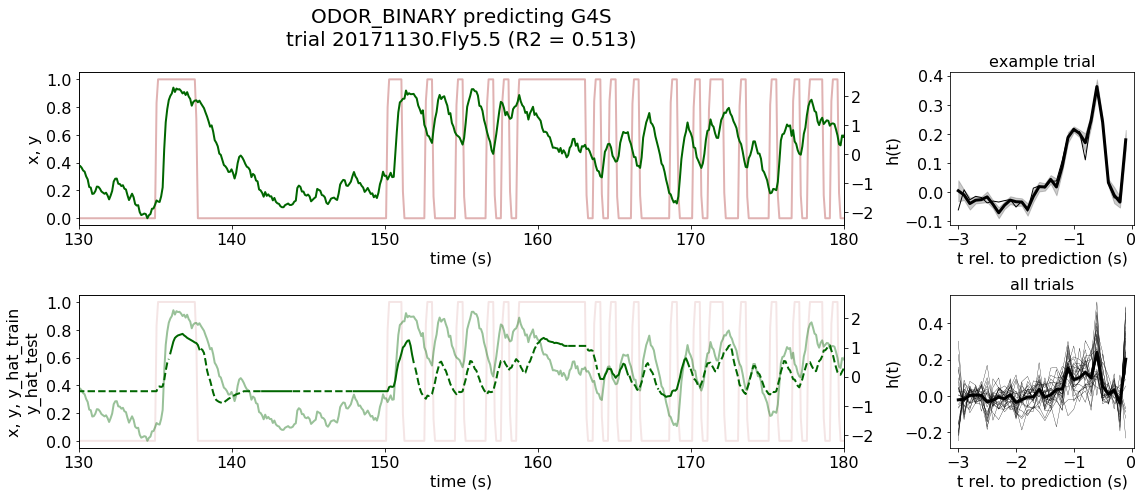

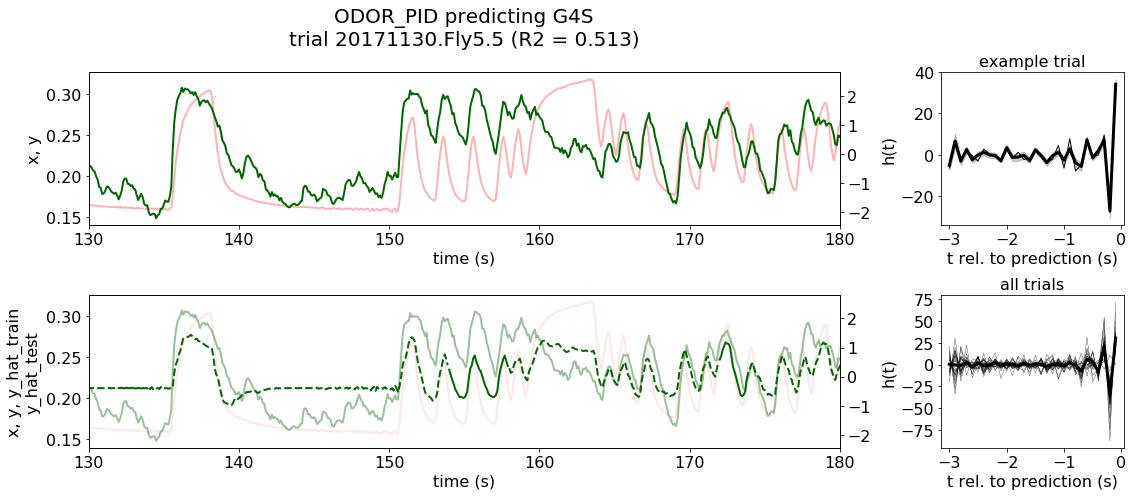

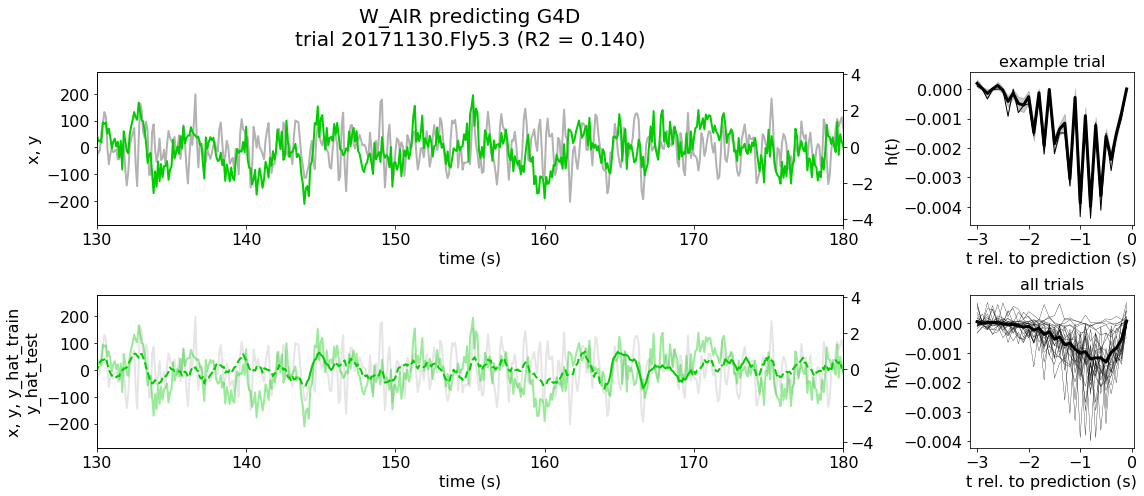

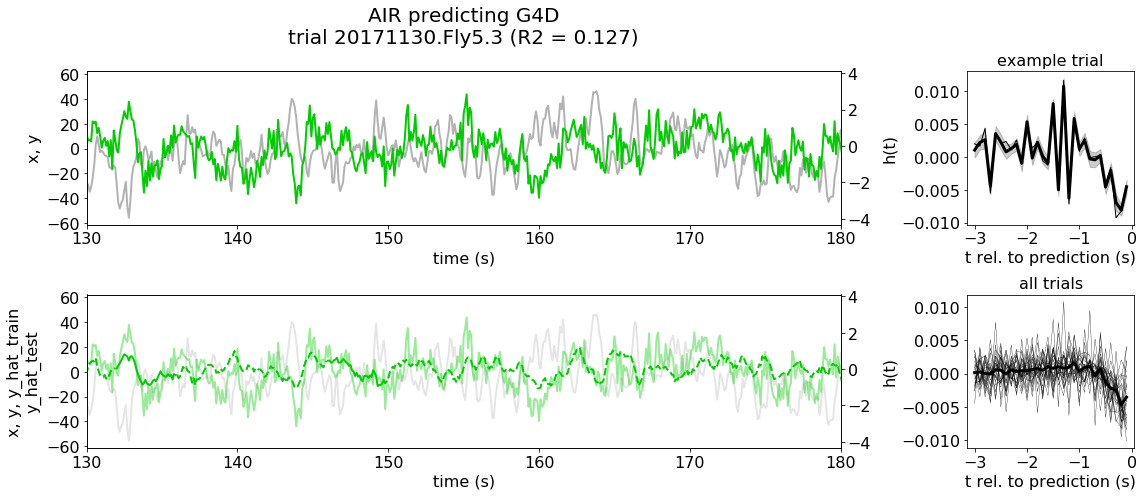

In [10]:
HS_PLOT = [
    ('20171130.Fly5.5', (130, 180), 'odor_binary', 'g4s'),
    ('20171130.Fly5.5', (130, 180), 'odor_pid', 'g4s'),
    ('20171130.Fly5.3', (130, 180), 'w_air', 'g4d'),
    ('20171130.Fly5.3', (130, 180), 'air', 'g4d'),
]

for trial_name, t_lim, x_name, y_name in HS_PLOT:
    
    rslt = df_xmpl.loc[trial_name][(x_name, y_name)]
    
    c_x = np.array(C.COLORS_RGB[x_name]) / 255
    c_y = np.array(C.COLORS_RGB[y_name]) / 255
    
    gs = gridspec.GridSpec(2, 4)
    
    fig = plt.figure(figsize=(16, 7), tight_layout=True)
    
    # plot x and y
    ax_0 = fig.add_subplot(gs[0, :3])
    ax_0.plot(t, rslt.x, color=c_x, lw=2, alpha=0.3)
    
    ax_0_twin = ax_0.twinx()
    
    ax_0_twin.plot(t, rslt.y, color=c_y, lw=2)
    
    ax_0.set_xlim(t_lim)
    
    ax_0.set_xlabel('time (s)')
    ax_0.set_ylabel('x, y')
    ax_0.set_title('{2} predicting {3}\ntrial {0} (R2 = {1:.3f})\n'.format(
        trial_name, rslt.r2_test, x_name.upper(), y_name.upper()))
    
    # plot x, y, y_hat_train, and y_hat_test
    ax_1 = fig.add_subplot(gs[1, :3])
    ax_1.plot(t, rslt.x, color=c_x, lw=2, alpha=0.1)
    
    ax_1_twin = ax_1.twinx()
    
    ax_1_twin.plot(t, rslt.y, color=c_y, lw=2, alpha=0.4)
    ax_1_twin.plot(t, rslt.y_hat_train, color=c_y, lw=2, ls='--')
    ax_1_twin.plot(t, rslt.y_hat_test, color=c_y, lw=2, ls='-')
    
    ax_1.set_xlim(t_lim)
    
    ax_1.set_xlabel('time (s)')
    ax_1.set_ylabel('x, y, y_hat_train\ny_hat_test')
    
    # plot filters
    ## example cross-split mean + std
    t_h, h_mean, h_std = df_h.loc[trial_name][(x_name, y_name)]
    
    ax_2 = fig.add_subplot(gs[0, 3])
    
    ### filter corresponding to example x, y trace
    ax_2.plot(rslt.t_h, rslt.h, color='k', lw=1)
    
    ### mean/stds of filters across all splits
    ax_2.plot(t_h, h_mean, color='k', lw=3)
    ax_2.fill_between(t_h, h_mean-h_std, h_mean+h_std, color='k', alpha=0.2)
    
    ax_2.set_xlabel('t rel. to prediction (s)')
    ax_2.set_ylabel('h(t)')
    ax_2.set_title('example trial')
    
    ## cross-trial mean
    t_hs = np.array([df_h.loc[trial.name][(x_name, y_name)][0] for trial in trials])
    h_means = np.array([df_h.loc[trial.name][(x_name, y_name)][1] for trial in trials])
    
    ax_3 = fig.add_subplot(gs[1, 3])
    
    ax_3.plot(t_hs.mean(0), h_means.T, color='k', lw=0.3)
    ax_3.plot(t_hs.mean(0), h_means.mean(0), color='k', lw=3)
    
    ax_3.set_xlabel('t rel. to prediction (s)')
    ax_3.set_ylabel('h(t)')
    ax_3.set_title('all trials')
    
    for ax in [ax_0, ax_0_twin, ax_1, ax_1_twin, ax_2, ax_3]:
        set_font_size(ax, 16)
        
        if ax not in [ax_2, ax_3]:
            ax.title.set_fontsize(20)

### Plot per-trial W_AIR --> G4D filters and R2 values

We do this to confirm that low R2s correspond to ugly filters.

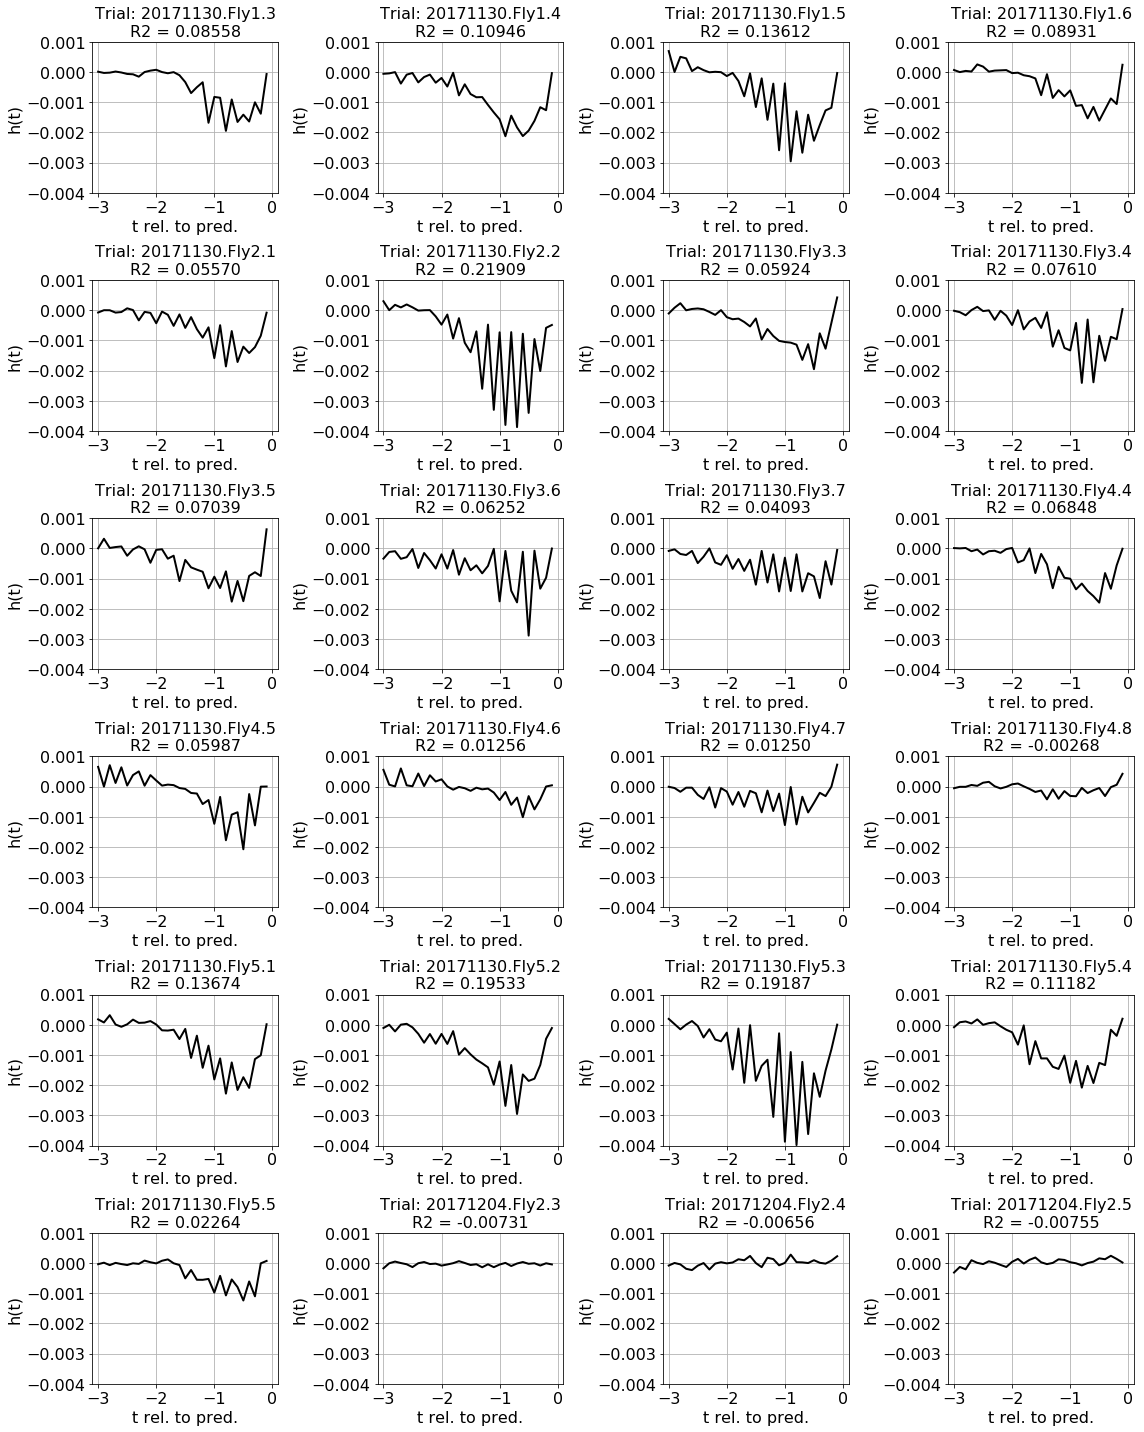

In [22]:
X_NAME = 'w_air'
Y_NAME = 'g4d'

fig, axs = plt.subplots(6, 4, figsize=(16, 20), tight_layout=True)

for trial, ax in zip(trials, axs.flatten()):
    
    t_h = df_h.loc[trial.name][(X_NAME, Y_NAME)][0]
    h_mean = df_h.loc[trial.name][(X_NAME, Y_NAME)][1]
    r2 = df_r2.loc[trial.name][(X_NAME, Y_NAME)]
    
    ax.plot(t_h, h_mean, lw=2, c='k')
    ax.set_title('Trial: {0}\nR2 = {1:.5f}'.format(trial.name, r2))
    
for ax in axs.flatten():
    
    ax.set_xlim(-3.1, 0.1)
    ax.set_ylim(-0.004, 0.001)
    
    ax.grid()
    
    ax.set_xlabel('t rel. to pred.')
    ax.set_ylabel('h(t)')
    
    set_font_size(ax, 16)